In [ ]:
!pip install torch-geometric
!pip install pyg-lib -f https://data.pyg.org/whl/torch-2.0.0+cu118.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 10.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=d8185cd45f619b47654f3542367f4b6c48ee8b2a7f75576b107df80f5117d687
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 4.7 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GATConv
from torch_geometric.datasets import CitationFull
from torch_geometric.data import DataLoader
from sklearn.metrics import f1_score,precision_score, recall_score
import torch.nn.functional as F
from torch.nn import Linear
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid

In [ ]:
dataset = Planetoid(root='.', name='Cora')

Processing...
Done!


In [ ]:
data=dataset[0]

In [ ]:
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {dataset[0].x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Has isolated nodes: {dataset[0].has_isolated_nodes()}')

Number of graphs: 1
Number of nodes: 2708
Number of features: 1433
Number of classes: 7
Has isolated nodes: False


In [ ]:
print(f'Training nodes: {sum(data.train_mask).item()}')
print(f'Evaluation nodes: {sum(data.val_mask).item()}')
print(f'Test nodes: {sum(data.test_mask).item()}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Training nodes: 140
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


In [ ]:
class GAT(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in, dim_h, dim_out,num_heads,dropout_rate,l2_reg):
    super().__init__()
    self.gat1 = GATConv(dim_in, dim_h, heads=num_heads, dropout=dropout_rate)
    self.gat2 = GATConv(dim_h*num_heads, dim_out, heads=1,concat=False, dropout=dropout_rate)
    self.dropout=nn.Dropout(dropout_rate)
    self.l2_reg=l2_reg

  def forward(self, x, edge_index):
    x = self.gat1(x, edge_index)
    x = F.elu(x)
    x = self.dropout(x)
    x = self.gat2(x, edge_index)
    return F.log_softmax(x, dim=1)

In [ ]:
def accuracy(pred_y, y):
    # mean accuracy #
    return ((pred_y == y).sum() / len(y)).item()

In [ ]:
def train(model, data):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),weight_decay=model.l2_reg)
    epochs = 100
    train_losses = []
    val_losses = []

    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train_acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'val_acc: {val_acc*100:.2f}%')


    return model

In [ ]:
def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

In [ ]:
gat = GAT(dataset.num_features, 8, dataset.num_classes, 8, 0.6, 0.0005)
print(gat)


GAT(
  (gat1): GATConv(1433, 8, heads=8)
  (gat2): GATConv(64, 7, heads=1)
  (dropout): Dropout(p=0.6, inplace=False)
)


In [ ]:
train(gat, data)

Epoch   0 | Train Loss: 1.955 | Train_acc:  14.29% | Val Loss: 1.95 | val_acc: 14.60%
Epoch  10 | Train Loss: 1.694 | Train_acc:  55.71% | Val Loss: 1.77 | val_acc: 42.80%
Epoch  20 | Train Loss: 1.381 | Train_acc:  77.86% | Val Loss: 1.64 | val_acc: 52.40%
Epoch  30 | Train Loss: 1.217 | Train_acc:  77.86% | Val Loss: 1.53 | val_acc: 58.80%
Epoch  40 | Train Loss: 1.096 | Train_acc:  80.71% | Val Loss: 1.42 | val_acc: 59.40%
Epoch  50 | Train Loss: 1.062 | Train_acc:  78.57% | Val Loss: 1.36 | val_acc: 60.20%
Epoch  60 | Train Loss: 0.947 | Train_acc:  82.14% | Val Loss: 1.31 | val_acc: 64.80%
Epoch  70 | Train Loss: 0.876 | Train_acc:  85.00% | Val Loss: 1.25 | val_acc: 64.80%
Epoch  80 | Train Loss: 0.758 | Train_acc:  86.43% | Val Loss: 1.23 | val_acc: 63.20%
Epoch  90 | Train Loss: 0.692 | Train_acc:  86.43% | Val Loss: 1.26 | val_acc: 59.00%
Epoch 100 | Train Loss: 0.574 | Train_acc:  90.71% | Val Loss: 1.16 | val_acc: 62.00%


GAT(
  (gat1): GATConv(1433, 8, heads=8)
  (gat2): GATConv(64, 7, heads=1)
  (dropout): Dropout(p=0.6, inplace=False)
)

In [ ]:
acc = test(gat, data)
print(f'GAT test Accuracy: {acc*100:.2f}%\n')

GAT test Accuracy: 77.10%



In [ ]:
from sklearn.manifold import TSNE

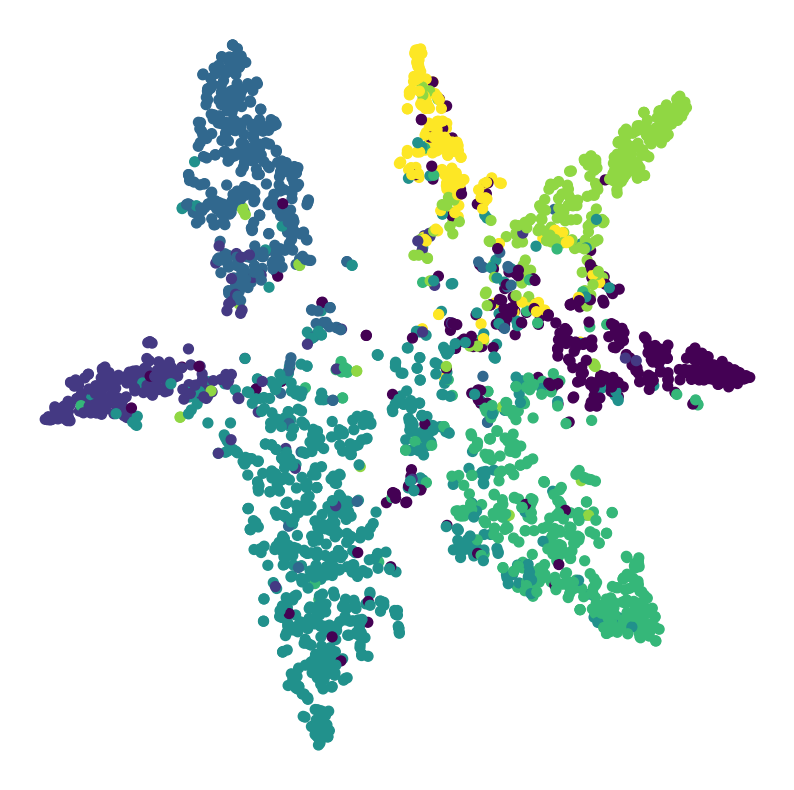

In [ ]:
x = gat(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(x.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()